In [1]:
import matplotlib.pyplot as plt
% matplotlib inline
import pandas as pd
import numpy as np
import glob
import os
import seaborn as sns; sns.set()
sns.set(style='white')

In [2]:
# see pvt-statistics for explanation of data loading and transformation -- I'm going to do it all in one step in this file

# data loading 

sample_control_temp = []
sample_treatment_temp = []

# open every files from folder: https://stackoverflow.com/a/18262324/9600186
# space separated: https://stackoverflow.com/a/19633103/9600186
# opening individual files because this way it's easy to distinguish individual sessions
path = 'data/control'
for filename in glob.glob(os.path.join(path, '*.iqdat')):
    with open(os.path.join(os.getcwd(), filename), 'r') as f: # open in readonly mode
        sample_control_temp.append(pd.read_csv(f, delim_whitespace=True))
path = 'data/treatment'
for filename in glob.glob(os.path.join(path, '*.iqdat')):
    with open(os.path.join(os.getcwd(), filename), 'r') as f: # open in readonly mode
        sample_treatment_temp.append(pd.read_csv(f, delim_whitespace=True))
    
# remove everything except for reaction times from the data
sample_control_temp = [session['rt'] for session in sample_control_temp]
sample_treatment_temp = [session['rt'] for session in sample_treatment_temp]

# turn lapses into 1s and everything else into 0s
for i, session in enumerate(sample_control_temp):
    for j, trial in enumerate(session):
        if (trial>=500):
            sample_control_temp[i][j] = 1
        else:
            sample_control_temp[i][j] = 0
            
for i, session in enumerate(sample_treatment_temp):
    for j, trial in enumerate(session):
        if (trial>=500):
            sample_treatment_temp[i][j] = 1
        else:
            sample_treatment_temp[i][j] = 0
            
# sum number of lapses in each session
# https://www.geeksforgeeks.org/python-ways-to-sum-list-of-lists-and-return-sum-list/
sample_control_temp = [sum(i) for i in zip(*sample_control_temp)]
sample_treatment_temp = [sum(i) for i in zip(*sample_treatment_temp)]

In [3]:
# separate control and treatment into days
sample_control = []
sample_treatment = []

# per protocol
sessions_per_day = 13

sample_control.append(sample_control_temp[0:sessions_per_day])
sample_control.append(sample_control_temp[sessions_per_day:2*sessions_per_day])
sample_control.append(sample_control_temp[2*sessions_per_day:3*sessions_per_day])
sample_treatment.append(sample_treatment_temp[0:sessions_per_day])
sample_treatment.append(sample_treatment_temp[sessions_per_day:2*sessions_per_day])
sample_treatment.append(sample_treatment_temp[2*sessions_per_day:3*sessions_per_day])

In [4]:
# packing lapses into dataframes by creating one row per session
# first np.full in every line fills sessions_per_day number of rows with the day on which sessions took place)
# second np.full in every line fills sessions_per_day number of rows with 
sample_control[0] = pd.DataFrame(list(zip(np.full(sessions_per_day,1), 
                                          sample_control[0])),
                                 columns=['day','lapses'])
sample_control[1] = pd.DataFrame(list(zip(np.full(sessions_per_day,19),
                                          sample_control[1])),
                                 columns=['day','lapses'])
sample_control[2] = pd.DataFrame(list(zip(np.full(sessions_per_day,20),
                                          sample_control[2])),
                                 columns=['day','lapses'])
sample_treatment[0] = pd.DataFrame(list(zip(np.full(sessions_per_day,13),
                                          sample_treatment[0])),
                                 columns=['day','lapses'])
sample_treatment[1] = pd.DataFrame(list(zip(np.full(sessions_per_day,14),
                                          sample_treatment[1])),
                                 columns=['day','lapses'])
sample_treatment[2] = pd.DataFrame(list(zip(np.full(sessions_per_day,15),
                                          sample_treatment[2])),
                                 columns=['day','lapses'])

In [5]:
# print(sample_control[0])

dataset constructed in accordance with: https://gist.github.com/guzey/5980c78a992517bae18ffe16e668f6b5

In [6]:
# creating arrays of days to be packed into the dataframe with lapses
days = np.arange(-7,22)
# https://stackoverflow.com/a/10996196/9600186
days = np.delete(days, 7)
days_of_sleep_deprivation = [1,2,3,
                             4,5,6,
                             7,8,1,
                             2,3,4,
                             5,6,7,
                             8,9,10,
                             11,12,13,
                             14,1,2,
                             3,1,2]

In [7]:
# setting lapses to 20 so matplotlib shows every day on the plot, 20s lapses are never shown on the plot
# initially I set these to 100, not 20 but this for some reason made random data points disappear from swarplot if size>=6....
lapses = np.full(27, 20)
# lapses = sample_control[0]

In [8]:
# merging days, hours of sleep and lapses into one dataframe
# https://www.geeksforgeeks.org/create-a-pandas-dataframe-from-lists/
df = pd.DataFrame(list(zip(days,lapses)), columns=['day','lapses'])
# remove fake 20s from the days where I have real data (or they wil will thought of as real data when drawing graphs!)
df = df.drop(df.index[[7,19,20,21,25,26]])

In [9]:
# appending real lapses that will be shown on the graph to the dataframe
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.append.html
df = df.append(sample_control[0], ignore_index=True)
df = df.append(sample_control[1], ignore_index=True)
df = df.append(sample_control[2], ignore_index=True)
df = df.append(sample_treatment[0], ignore_index=True)
df = df.append(sample_treatment[1], ignore_index=True)
df = df.append(sample_treatment[2], ignore_index=True)

In [10]:
# based on https://stackoverflow.com/a/53383764/9600186
def draw_brace(ax, xspan, yy, text):
    '''Draws an annotated brace on the axes.'''
    xmin, xmax = xspan
    xspan = xmax - xmin
    ax_xmin, ax_xmax = ax.get_xlim()
    xax_span = ax_xmax - ax_xmin
    
    ymin, ymax = ax.get_ylim()
    yspan = ymax - ymin
    resolution = int(xspan/xax_span*100)*2+1 # guaranteed uneven
    beta = 300./xax_span # the higher this is, the smaller the radius

    x = np.linspace(xmin, xmax, resolution)
    x_half = x[:int(resolution/2)+1]
    y_half_brace = (1/(1.+np.exp(-beta*(x_half-x_half[0])))
                    + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
    y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
    y = yy - (.05*y - .01)*yspan # adjust vertical position

    ax.autoscale(False)
# https://stackoverflow.com/questions/9912206/how-do-i-let-my-matplotlib-plot-go-beyond-the-axes
    ax.plot(x, y, color='black', lw=1, clip_on=False)

    ax.text((xmax+xmin)/2., yy-.13*yspan, text, ha='center', va='bottom', fontsize=20)

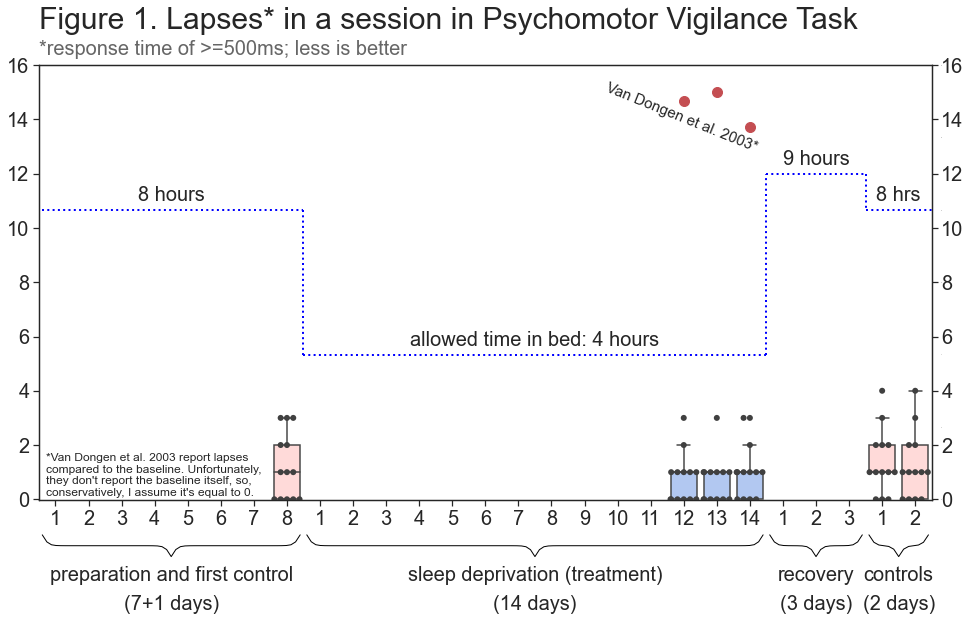

In [11]:
# parameters
# https://stackoverflow.com/questions/332289/how-do-you-change-the-size-of-figures-drawn-with-matplotlib#comment47852929_332289
plt.figure(figsize=(16,8))
# https://stackoverflow.com/a/53086342/9600186
plt.tick_params(labelsize=20)

# drawing boxplots and swarplots which show all datapoints
# https://seaborn.pydata.org/generated/seaborn.boxplot.html
# hide outliers: https://www.mikulskibartosz.name/how-to-remove-outliers-from-seaborn-boxplot-charts/
ax = sns.boxplot(x='day', y='lapses', data=df, showfliers=False)
ax = sns.swarmplot(x='day', y='lapses', data=df, color='0.25', size=6)
# https://stackoverflow.com/a/43393545/9600186
ax.set(ylim=(-0.03, 16), ylabel='', xlim=(-0.5,26.5), xlabel='')
# https://stackoverflow.com/a/45731070/9600186
ax.set_xticklabels(days_of_sleep_deprivation, fontsize=20)

# coloring boxcharts https://www.pinterest.ru/pin/131378514108343305/
for i in [7,25,26]:
    ax.artists[i].set_facecolor('#ffdad9')
    
for i in [19,20,21]:
    ax.artists[i].set_facecolor('#b2c8f1')

# setting the right axis
# https://stackoverflow.com/questions/14762181/adding-a-y-axis-label-to-secondary-y-axis-in-matplotlib
ax2 = plt.twinx()
ax2.set(ylim=(-0.02, 12), ylabel='')

# setting font sizes that didn't get set in by tick_params
# https://stackoverflow.com/a/12892526/9600186
for label in ax2.yaxis.get_majorticklabels():
        label.set_fontsize(0)
# https://stackoverflow.com/a/10404895/9600186
ax.yaxis.label.set_size(20)
ax.xaxis.label.set_size(20)
# ax2.yaxis.label.set_size(20)
ax2.tick_params(right=False)

# https://brohrer.github.io/matplotlib_ticks.html#opposite
# https://stackoverflow.com/a/12651723/9600186
ax.tick_params(bottom=True, right=True, labelright=True)

# plt.text(5.5, 12.15, 'mean:')
# plt.text(6.7, 12.15, str(np.round(np.mean(sample_control[0])['lapses'], 1)))
# plt.text(18.7, 12.15, str(np.round(np.mean(sample_treatment[0])['lapses'], 1)))
# plt.text(19.7, 12.15, str(np.round(np.mean(sample_treatment[1])['lapses'], 1)))
# plt.text(20.7, 12.15, str(np.round(np.mean(sample_treatment[2])['lapses'], 1)))
# plt.text(24.7, 12.15, str(np.round(np.mean(sample_control[1])['lapses'], 1)))
# plt.text(25.7, 12.15, str(np.round(np.mean(sample_control[2])['lapses'], 1)))

# drawing hours of sleep and braces here because hours of sleep axis will be the same across experiments, so coordinates of
# everything stay the same
# drawing the hours of sleep line
# dashed: https://www.science-emergence.com/Articles/How-to-plot-a-dashed-line-in-matplotlib-/
# zorder: https://www.science-emergence.com/Articles/How-to-plot-points-in-front-of-a-line-in-matplotlib-/
# and https://stackoverflow.com/questions/31506361/grid-zorder-seems-not-to-take-effect-matplotlib#comment96363710_53584883
# line: https://stackoverflow.com/a/36148001/9600186
# color: https://stackoverflow.com/questions/41709257/how-to-change-the-plot-line-color-from-blue-to-black
plt.plot([-0.4, 7.5], [8, 8], ':', linewidth=2, color='blue', zorder=-1)
plt.plot([7.5, 7.5], [8, 4], ':', linewidth=2, color='blue', zorder=-1)
plt.plot([7.5, 21.5], [4, 4], ':', linewidth=2, color='blue', zorder=-1)
plt.plot([21.5, 21.5], [4, 9], ':', linewidth=2, color='blue', zorder=-1)
plt.plot([21.5, 24.5], [9, 9], ':', linewidth=2, color='blue', zorder=-1)
plt.plot([24.5, 24.5], [9, 8], ':', linewidth=2, color='blue', zorder=-1)
plt.plot([24.5, 27], [8, 8], ':', linewidth=2, color='blue', zorder=-1)

# writing text by drawing invisible braces...
draw_brace(ax2, (3.5, 3.5), 9.7, '8 hours')
draw_brace(ax2, (14.5, 14.5), 5.7, 'allowed time in bed: 4 hours')
draw_brace(ax2, (23, 23), 10.7, '9 hours')
draw_brace(ax2, (25.5, 25.5), 9.7, '8 hrs')

draw_brace(ax2, (-0.4, 7.4), -0.8, 'preparation and first control')
draw_brace(ax2, (3.5, 3.5), -1.6, '(7+1 days)')
draw_brace(ax2, (7.6, 21.4), -0.8, 'sleep deprivation (treatment)')
draw_brace(ax2, (14.5, 14.5), -1.6, '(14 days)')
draw_brace(ax2, (21.6, 24.4), -0.8, 'recovery')
draw_brace(ax2, (23, 23), -1.6, '(3 days)')
draw_brace(ax2, (24.6, 26.4), -0.8, 'controls')
draw_brace(ax2, (25.5, 25.5), -1.6, '(2 days)')

# van dongen data points
plt.plot(19, 11, 'ro', markersize=10)
plt.plot(20, 11.25, 'ro', markersize=10)
plt.plot(21, 10.3, 'ro', markersize=10)
plt.text(16.6, 9.6, 'Van Dongen et al. 2003*', rotation=-22, fontsize=15)
plt.text(-0.3, 0.1, '*Van Dongen et al. 2003 report lapses\ncompared to the baseline. Unfortunately,\nthey don\'t report the baseline itself, so,\nconservatively, I assume it\'s equal to 0.', fontsize=12)

# https://python-graph-gallery.com/4-add-title-and-axis-label/
plt.text(-0.5, 13, 'Figure 1. Lapses* in a session in Psychomotor Vigilance Task', fontsize=30)
plt.text(-0.5, 12.3, '*response time of >=500ms; less is better', fontsize=20, color='0.4')

# https://cmdlinetips.com/2019/10/how-to-make-a-plot-with-two-different-y-axis-in-python-with-matplotlib/
# https://stackoverflow.com/a/59305136/9600186
plt.savefig('pvt.png',
            format='png',
            dpi=100,
            bbox_inches='tight')